In [19]:
from os.path import join as pjoin
from os import listdir as dirlist
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
import torch
import torch.nn as nn

class Dehazer(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Dehazer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
class PerceptualLoss(nn.Module):
    def __init__(self, net, gamma=0.0):
        super(PerceptualLoss, self).__init__()
        self.net = net
        self.gamma = gamma
        self.net.eval()
        
    def forward(self, output, target):
        # Extract features from the VGG16 model for output and target
        output_features = self.net(output)
        target_features = self.net(target)

        # Compute the L2 distance between the features
        perceptual_loss = nn.MSELoss()(output_features, target_features)
        
        # pixel wise loss
        pixel_loss = nn.MSELoss()(output, target)
         
        return perceptual_loss + self.gamma * pixel_loss

In [4]:
def list_train_test_split(data_dir):
    imgs = []
    for i in sorted(dirlist(pjoin(data_dir, "GT"))):
        img_path = pjoin(data_dir, "GT", i)
        imgs.append(img_path)

    train_split = 0.8
    train_samples = random.sample(imgs, int(0.8*len(imgs)))

    with open(pjoin(data_dir, "test.txt"), "w") as f1:
        with open(pjoin(data_dir, "train.txt"), "w") as f2:
            for s in imgs:
                if s in train_samples:
                    f2.write(s+"\n")
                else:
                    f1.write(s+"\n")

# list_train_test_split("ohaze")

In [5]:
class OHaze(Dataset):
    def __init__(self, data_dir, mode="train", transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.x = []
        self.y = []
        with open(pjoin(data_dir, mode+".txt"), "r") as f:
            for line in f.readlines():
                self.x.append(line.strip().replace("GT", "hazy"))        
                self.y.append(line.strip())
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = Image.open(self.x[idx])
        target = F.to_tensor(F.center_crop(Image.open(self.y[idx]), 400))

        if self.transform is not None:
            image = self.transform(image)

        return image, target

In [6]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(400), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])          
])

train_dataset = OHaze("ohaze", mode="train", transform=transform)
test_dataset = OHaze("ohaze", mode="test", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [13]:
print(feat_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Obtain the ResNet-18 model from the torchvision model hub

model = Dehazer()

# Loss
vgg_model = models.vgg16(pretrained=True).features
feat_extractor = nn.Sequential(*list(vgg_model.children())[:17])  # from relu4_2 layer
feat_extractor.to(device)
criterion = PerceptualLoss(feat_extractor, gamma=0.01)

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.to(device)

num_epochs = 500

for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/500], Loss: 5.3272


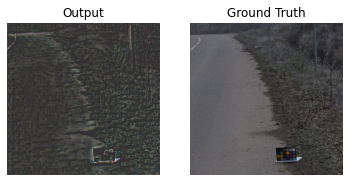

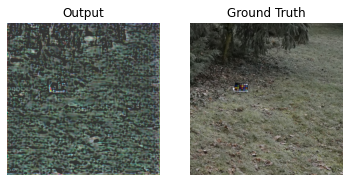

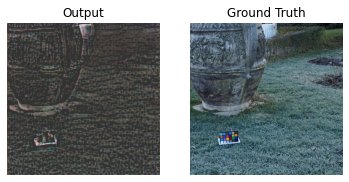

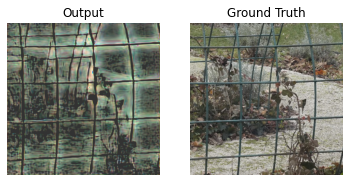

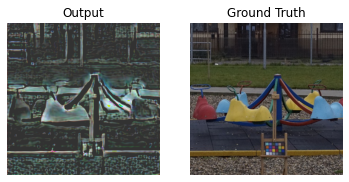

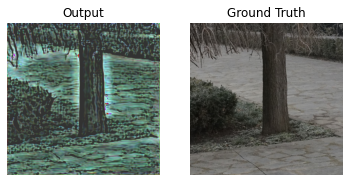

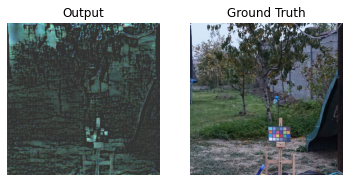

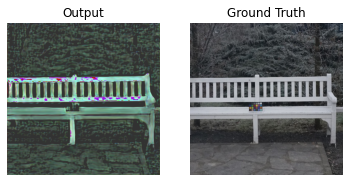

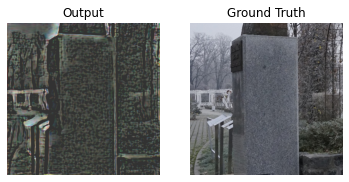

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)

        # Convert the outputs and targets to numpy arrays
        outputs_np = outputs.cpu().numpy()
        targets_np = targets.numpy()

        
        batch_size = outputs.shape[0]

        for i in range(batch_size):
            # Plot the results
            fig, axs = plt.subplots(1, 2)
            
#             out_range = (np.max(outputs_np[0]), np.min(outputs_np[0]))
#             print(out_range)
            
            # get channel-wise max
            maxes = []
            for c in range(3):
                maxes.append(outputs_np[i][c].max())
            maxes = np.array(maxes)
            
            # normalize using max values
            for c in range(3):
      
                outputs_np[i][c] /= maxes[c]
            outputs_np[i] *= 255
            
            output = outputs_np[i].astype("uint8")
            
            axs[0].imshow((output+50).transpose(1, 2, 0))
            axs[0].set_title("Output")
            axs[0].axis("off")

            axs[1].imshow(targets_np[i].transpose(1, 2, 0))
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            plt.show()
